In [1]:
import pandas as pd

# Load the submissions and comments data from files
submissions_df = pd.read_json('data/subreddit/ed_sub', lines=True)
comments_df = pd.read_json('data/subreddit/ed_comm', lines=True)

# Prepare the data
# Remove the 't3_' prefix from 'link_id' in comments_df to match the 'id' in submissions_df
comments_df['link_id'] = comments_df['link_id'].str.replace('t3_', '')

# Merge the DataFrames on the 'id' of submissions and 'link_id' of comments
merged_df = pd.merge(submissions_df, comments_df, left_on='id', right_on='link_id', how='left', suffixes=('_sub', '_com'))


print(merged_df.head())

   archived_sub author_sub author_flair_background_color_sub  \
0           1.0    dbenhur                              None   
1           1.0    dbenhur                              None   
2           1.0    Netizen                              None   
3           1.0    Netizen                              None   
4           1.0       oska                              None   

  author_flair_css_class_sub author_flair_richtext_sub author_flair_text_sub  \
0                       None                        []                  None   
1                       None                        []                  None   
2                       None                        []                  None   
3                       None                        []                  None   
4                       None                        []                  None   

  author_flair_text_color_sub author_flair_type_sub  brand_safe  can_gild_sub  \
0                        None                  text  

In [2]:
len(merged_df)

809079

In [3]:
column_names = merged_df.columns.tolist()
print(column_names)

['archived_sub', 'author_sub', 'author_flair_background_color_sub', 'author_flair_css_class_sub', 'author_flair_richtext_sub', 'author_flair_text_sub', 'author_flair_text_color_sub', 'author_flair_type_sub', 'brand_safe', 'can_gild_sub', 'contest_mode', 'created_utc_sub', 'distinguished_sub', 'domain', 'edited_sub', 'gilded_sub', 'hidden', 'hide_score', 'id_sub', 'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked_sub', 'media', 'media_embed', 'no_follow_sub', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink_sub', 'retrieved_on_sub', 'rte_mode_sub', 'score_sub', 'secure_media', 'secure_media_embed', 'selftext', 'send_replies_sub', 'spoiler', 'stickied_sub', 'subreddit_sub', 'subreddit_id_sub', 'subreddit_name_prefixed_sub', 'subreddit_type_sub', 'suggested_sort', 'thumbnail', 'thumbnail_height', 'thumbnail_width', 'titl

In [4]:
# Convert 'created_utc_sub' to datetime format
merged_df['created_utc_sub'] = pd.to_datetime(merged_df['created_utc_sub'], unit='s')

# Extract the year from the datetime
merged_df['Year'] = merged_df['created_utc_sub'].dt.year

# Filter the DataFrame for the years 2018, 2019, 2020, 2021, and 2022
filtered_df = merged_df[merged_df['Year'].isin([2018, 2019, 2020, 2021, 2022])]

# Display the first few rows of the filtered DataFrame
print(filtered_df.head())

        archived_sub        author_sub author_flair_background_color_sub  \
524309           0.0          VU-Guide                               NaN   
524310           0.0   educationtopten                               NaN   
524311           0.0          madhavkr                               NaN   
524312           0.0       sheetal0303                               NaN   
524313           0.0  nelsonpattrick43                               NaN   

       author_flair_css_class_sub author_flair_richtext_sub  \
524309                       None                       NaN   
524310                       None                       NaN   
524311                       None                       NaN   
524312                       None                       NaN   
524313                       None                       NaN   

       author_flair_text_sub author_flair_text_color_sub  \
524309                  None                         NaN   
524310                  None                

In [5]:
len(filtered_df)

284770

In [6]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

# Filter out rows where 'body' is NaN
filtered_df = filtered_df.dropna(subset=['body'])

# Apply the function to each comment
filtered_df['Sentiment'] = filtered_df['body'].apply(calculate_sentiment)

# Display the first few rows to verify
print(filtered_df[['body', 'Sentiment']].head())


                                                     body  Sentiment
524332                                          [deleted]   0.000000
524333  Public school teacher. Students absolutely sti...   0.100000
524334                                          [deleted]   0.000000
524335                                   Lol, high-five.    0.800000
524336  Also a teacher.  Can confirm, students still l...  -0.133333


In [7]:
from transformers import pipeline
from tqdm import tqdm
import time

tqdm.pandas()

# Load the pipeline for text classification
classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", truncation=True)

def detect_emotion(text):
    try:
        if pd.isnull(text) or text.strip() == "":
            return None
        # Use the classifier directly
        result = classifier(text)
        # The result is a list of dictionaries, each with 'label' and 'score' keys
        predicted_label = result[0]['label']
        return predicted_label
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Filter out rows where 'body' is '[deleted]' or too short
filtered_df_clean = filtered_df[(filtered_df['body'] != '[deleted]') & (filtered_df['body'].str.len() > 3)]

# Initialize timing
start_time = time.time()

# Apply the emotion analysis on the cleaned DataFrame with a progress bar
filtered_df_clean['Emotions'] = filtered_df_clean['body'].progress_apply(detect_emotion)

# Calculate and print processing time
end_time = time.time()
print(f"Processing completed in {(end_time - start_time):.2f} seconds.")

# Write results to CSV
filtered_df_clean.to_csv('data/edu_sent_emo.csv', index=False)

print("Results have been written to 'edu_sent_emo.csv'.")



100%|██████████| 145873/145873 [1:27:07<00:00, 27.90it/s]
/var/folders/vz/xnvh56_d73j4fb9pp3_7c9k40000gn/T/ipykernel_1783/2592505460.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_clean['Emotions'] = filtered_df_clean['body'].progress_apply(detect_emotion)


Processing completed in 5227.89 seconds.
Results have been written to 'edu_sent_emo.csv'.


/var/folders/vz/xnvh56_d73j4fb9pp3_7c9k40000gn/T/ipykernel_1783/3612492627.py:3: DtypeWarning: Columns (0,2,3,4,5,6,7,9,12,21,23,24,25,26,27,29,32,33,34,38,40,43,44,48,52,64,68,70,73,74,84,85,90,91,100,102,104,105,107,109,113,115,117,122,131,133,141,145,146,147,154,163,173,176,182,186,188,189,193,196) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/edu_sent_emo.csv')


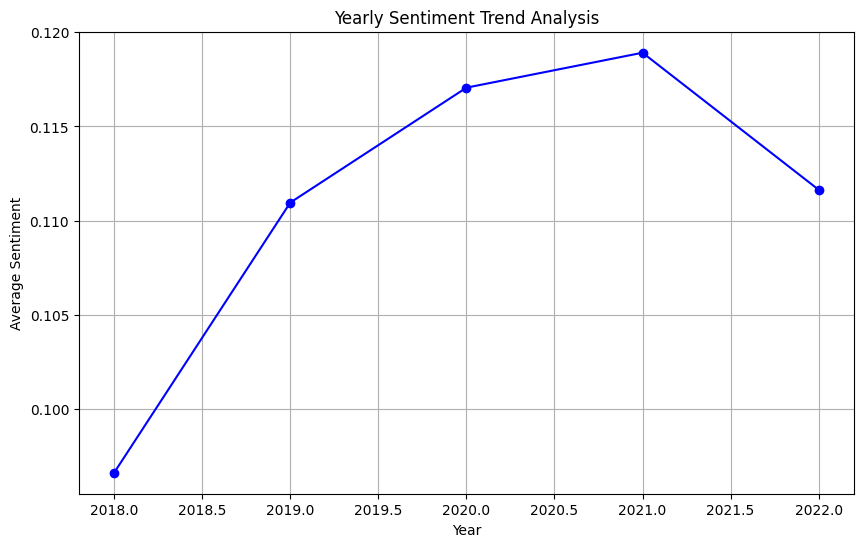

In [8]:
import matplotlib.pyplot as plt

df = pd.read_csv('data/edu_sent_emo.csv')

# Convert 'created_utc_sub' to datetime and extract the year
df['Year'] = pd.to_datetime(df['created_utc_sub']).dt.year

# Aggregate the data by 'Year' and calculate the mean sentiment
yearly_sentiment = df.groupby('Year')['Sentiment'].mean().reset_index()

# Plotting the trend of sentiment over years
plt.figure(figsize=(10, 6))
plt.plot(yearly_sentiment['Year'], yearly_sentiment['Sentiment'], marker='o', linestyle='-', color='b')

# Setting the title and labels
plt.title('Yearly Sentiment Trend Analysis')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.grid(True)

# Show the plot
plt.show()